# Deep Learning on Sign Language MNIST

In this notebook, deep learning techniques are carried out on the Sign Language MNIST dataset following the _universal workflow of machine learning_ presented in Chapter 4.5 of the book "Deep Learning With Python" by François Chollet.

[Introduction](#intro)

-   [The problem and the Dataset](#intro_1)
-   [Measure of Success](#intro_2)
-   [Evaluation Protocol](#intro_3)

[Implementation](#impl)

-   [Data Preperation](#impl_1)
-   [Establishing a baseline](#impl_2)
-   [Develop first Modal](#impl_3)
-   [Model that overfits](#impl_4)
-   [Regularization](#impl_5)
-   [Hyperparameter Tuning](#impl_6)
-   [Evaluation](#impl_7)

[Conclusion](#concl)


## Introduction <a class="anchor" id="intro"></a>

The American Sign Language (ASL) is an essential communication tool for many deaf and hard of hearing individuals in the United States and parts of Canada. It functions as a complete language expressed through hand signs, body movements, and facial expressions. Despite the importance of ASL in facilitating communication for the deaf and hard of hearing, there remains a significant communication barrier between ASL users and those unfamiliar with it. This gap presents a challenge in scenarios where direct human interpretation is unavailable, such as digital communication platforms.

Deep Learning, particularly through the use of dense neural networks, present a promising approach to bridge this gap. By utilizing the depth and complexity of dense layers, these networks can process and analyze images of hand gestures to capture the patterns and nuances that differentiates one ASL letter from another. By leveraging these capabilities, it is feasible to train dense neural networks on diverse ASL hand gesture images, then further fine tuned to accurately recognise ASL letters from images of hand gestures. Thus, enabling real-time interpretation of sign language into text or speech. This approach will significantly enhance accessibility for ASL users when interacting with the broader community, and play a crucial role in dismantling communication barriers.


### Defining the problem <a id="intro_1"></a>

The primary goal of this project is to leverage Deep Learning, particularly Dense Neural Networks, to develop a model capable of accurately identifying ASL letters. To achieve this goal, the [Sign Language MNIST](https://www.kaggle.com/datasets/datamunge/sign-language-mnist) dataset from Kaggle has been chosen. This dataset comprises images of hand gestures that correspond to letters of the ASL alphabet. Mimicking the traditional MNIST dataset, the Sign Language MNIST dataset represents hand gestures as 28x28 pixel grayscale images encoded within a CSV file.

Despite the ASL alphabet encompassing a complete set of 26 letters from A to Z, the Sign Language MNIST dataset is constrained to 24 letters, omitting J and Z. This limitation arises from the fact that the letters J and Z require movement, rendering them incompatible with the scope of this image classification task which requires static representation of images.

The final developed model is expected to distinguish among the 24 possible classes based on the input of 28x28 pixel grayscale images, making this task a **multiclass classification problem**.


### Measure of Success <a id="intro_2"></a>

In the context of this multiclass classification task, **Accuracy** is chosen as the primary metric for evaluating model's performance. This metric measures the proportion of correct predictions out of all predictions made, which makes it highly effective in scenarios where each class within the dataset is uniformly represented.

Given that the Sign Language MNIST dataset is specially curated for such multiclass classification tasks, it is presumed to have a balanced distribution of samples across its 24 classes (this will be verified during implementation). This makes accuracy the most suitable and reliable metric for this problem.


### Evaluation Protocol <a id="intro_3"></a>

The dataset contains 34627 samples in total, and is pre-split into 27455 of train data (~80% of total) and 7172 of test data (~20% of total). Given the large dataset size, **hold-out validation** is chosen as the evaluation protocol since it is straightforward and computationally less intensive. Additionally, as the train data set in itself is large, it it perfectly sufficient for further splitting into a training and validation set without negatively impacting the performance of the model.

In hold-out validation, the dataset is split into a training set, a validation set, and a test set. By splitting into these sets of data, the model can first be trained on the training set, tuned with the validation set, and then evaluated on the unseen test set.


## Implementation <a class="anchor" id="impl"></a>


### Data Preparation <a id="impl_1"></a>

The first step to the implementation is to load and prepare the data so that it can be fed into the neural network model.


In [9]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, ParameterGrid

import tensorflow as tf
from keras import backend as K
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2, l1_l2

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

# set random seed
MY_SEED = 42
tf.random.set_seed(MY_SEED)
np.random.seed(MY_SEED)

#### Load data from CSV

Two CSV files has been downloaded from [Sign Language MNIST](https://www.kaggle.com/datasets/datamunge/sign-language-mnist) on Kaggle. One contains the train data and the other contains the test data. Both will be loaded into this notebook, then checked for any missing values.


In [11]:
# load train and test data
train_df = pd.read_csv("data/sign_mnist_train.csv")
test_df = pd.read_csv("data/sign_mnist_test.csv")

print("Train data: ", train_df.shape)
print("Test data: ", test_df.shape)

Train data:  (27455, 785)
Test data:  (7172, 785)


In [12]:
# show unique labels
print("Train: ", np.sort(train_df["label"].unique()))
print("Test: ", np.sort(test_df["label"].unique()))

Train:  [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Test:  [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


In [13]:
# check for missing values
print(f"Train Data: {train_df.isnull().sum().sum()} missing values")
print(f"Test Data: {test_df.isnull().sum().sum()} missing values")

Train Data: 0 missing values
Test Data: 0 missing values


#### Class distribution

With no missing values detected in either set of data, the distribution of classes will now be verified. As the dataset has 24 classes in total, it is considered to be well distributed if each class makes up approximately $\frac{100\%}{24\,\mathrm{classes}} \approx 4\%$ of the total set of data.


In [14]:
def plot_distribution(df, title):
    """
    Plot the frequency and percentage distribution of labels in the dataset
    """
    labels = df["label"].values
    unique, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(15, 8))

    # plot the frequency of each label
    plt.subplot(1, 2, 1)
    sns.countplot(x="label", data=df, hue="label", palette="muted", legend=False)
    plt.title("Frequency", fontsize=16)

    # plot the percentage of each label
    plt.subplot(1, 2, 2)
    plt.pie(
        counts,
        labels=unique,
        autopct="%1.2f%%",
        startangle=90,
        counterclock=False,
        colors=sns.color_palette("muted"),
        pctdistance=0.85,
        labeldistance=1.03,
    )
    plt.axis("equal")
    plt.title("Percentage", fontsize=16)
    plt.suptitle(title, fontsize=18, fontweight="bold")
    plt.tight_layout()
    plt.show()

**Result**

Looking at the plot below, the bar chart on the left shows the frequency count for each of the 24 classes. Since the ASL letters from A to Z are mapped directly to the labels starting from 0 (e.g., A=0, B=1, C=2, etc), it can be observed that the label 9 is not included in the graph as it maps to letter J which has been omitted from this dataset as explained previously.

To get a better visualisation, the pie chart on the right displays the distribution percentage of each class. The result confirms that each class does indeed make up approximately 4% of the total training data set, which suggests that the data is fairly balanced. As such, the metric of Accuracy can be used.


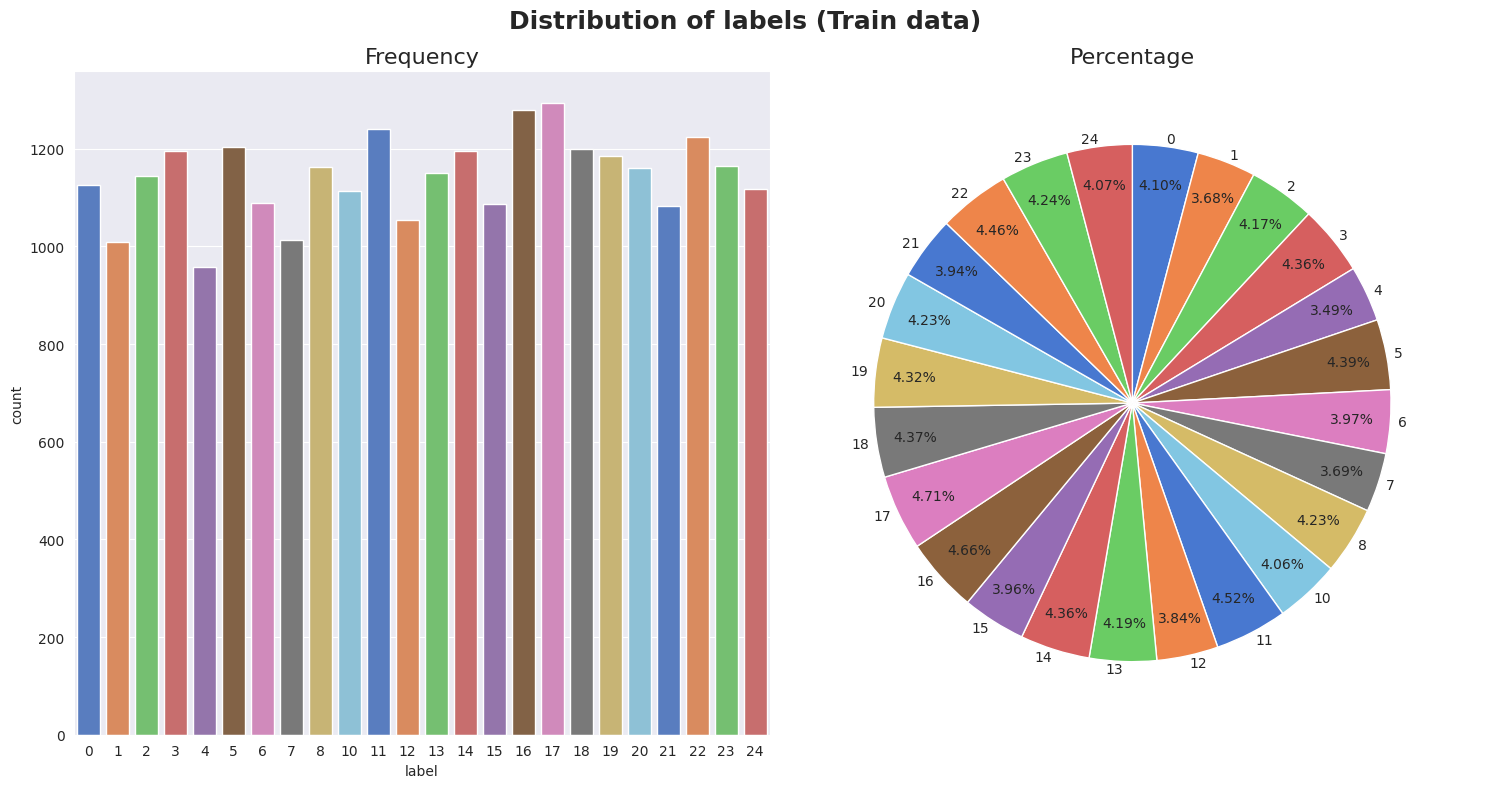

In [15]:
# plot distribution of labels in train data
plot_distribution(train_df, "Distribution of labels (Train data)")

#### Create Validation Set

The next step is to prepare the data so that there are three sets: training, validation, and testing, which is required to adhere to the chosen evaluation protocol of hold-out validation. To achieve this, the training data will be split into training and validation sets in a ratio that allows the validation set to have approximately the same size as the test set.


In [16]:
# calculate ratio to split
val_ratio = test_df.shape[0] / train_df.shape[0]

train_df, val_df = train_test_split(train_df, test_size=val_ratio, random_state=42)

# check shapes after split
print("Train Set: ", train_df.shape)
print("Validation Set: ", val_df.shape)
print("Test Set: ", test_df.shape)

Train Set:  (20283, 785)
Validation Set:  (7172, 785)
Test Set:  (7172, 785)


#### Pre-process the data

To prepare the data for training and evaluation in a dense neural network model, several pre-processing steps will be carried out.

1. Extract features (X) and labels (y).

2. Normalise the features so that pixel values are scaled from the range 0-255 to 0-1. Doing this ensures that all input features contribute equally to the training process.

3. Map and re-index the labels into a continuous range of integer values. As pointed out previously, the label "9" is missing from the dataset due to the letter "J" being excluded. This leads to an inconsistency during the one-hot encoding process, which later impacts the model's performance during training. Therefore, mapping will be done to ensure that the data is consistent.

4. One-hot encode the labels. In this process, each label is represented as a binary vector of length equal to the number of classes. This step is important for multiclass classification problems where each class output should be treated as independent, so as to allow accurate learning and prediction.

The `process_data` helper function below has been implemented to carry out the pre-processing steps.


In [17]:
def preprocess_data(df):
    """
    Preprocesses a DataFrame by extracting features and labels,
    normalizing the features, mapping and reindexing labels
    before one-hot encoding the labels.
    """
    # extract features and labels
    X = df.drop("label", axis=1).values
    y = df["label"].values

    # normalize the pixel values
    X = X / 255.0

    # map labels to integers
    labels = df["label"].unique()
    label_map = {label: i for i, label in enumerate(sorted(labels))}
    y = np.array([label_map[label] for label in y])

    # one-hot encode labels
    y = to_categorical(y)

    return X, y

In [18]:
# preprocess all sets of data
X_train, y_train = preprocess_data(train_df)
X_val, y_val = preprocess_data(val_df)
X_test, y_test = preprocess_data(test_df)

Below shows the plot of the first 10 samples from the training set for better visualisation of how the pixels makes up the images.


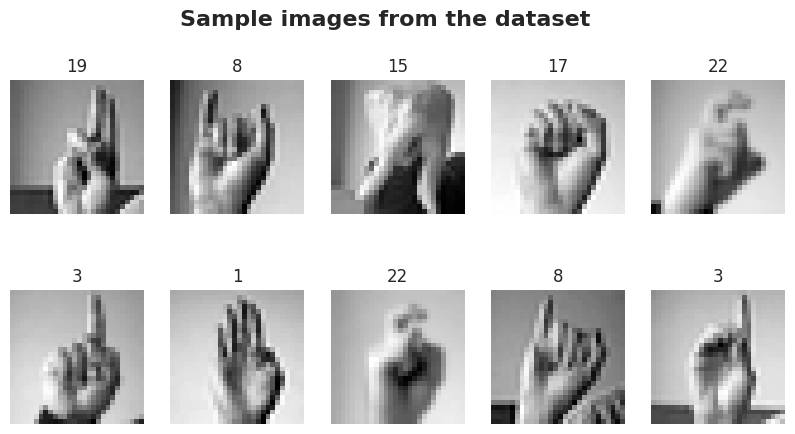

In [19]:
def plot_images(X, y, title):
    """
    Plots a grid of images with their corresponding labels
    """
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap="gray")
        plt.title(np.argmax(y[i]))
        plt.axis("off")

    plt.suptitle(title, fontsize=16, fontweight="bold")
    plt.show()


plot_images(X_train, y_train, "Sample images from the dataset")

### Establishing a Baseline <a id="impl_2"></a>

A common-sense baseline will be calculated using the Random Guessing approach where prediction is made by randomly selecting from the set of all possible classes. Since there are 24 classes in total, the expected accuracy of random guessing would be about 4.17% as calculated below.


In [20]:
# calculate baseline accuracy
unique_labels = len(np.unique(train_df["label"]))
baseline_accuracy = 1 / unique_labels
print(f"Baseline Accuracy: {round(baseline_accuracy * 100, 2)}%")

Baseline Accuracy: 4.17%


### Develop first model <a id="impl_3"></a>

With the baseline established, a basic modal will now be created with the goal of performing better than the baseline accuracy of 4.17%. This will be a simple neural network model consisting of a single Dense layer with 24 units.

One important consideration when designing a neural network is the choice of **last-layer activation** and **loss function**. As the current task is a multiclass, single-label classification problem, the `softmax` function will be used for the last-layer activation with `categorical_crossentropy` as the loss function. The use of softmax ensures that the outputs can be interpreted as probabilities, while categorical crossentropy compares the predicted probability distribution with the actual distribution. The combination of both allows the model to effectively learn from the data to produce meaningful predictions.

The model will be compiled using the **Adam optimizer** as it is widely used in image classification tasks due to its efficiency and ease of use. Lastly, the **accuracy metric** is chosen as a criterion to track the model's performance as it is straightforward and suitable for the current task.


In [21]:
def compile_and_train(model, lr=0.001, epochs=10, stop=None):
    """
    Compiles and trains the given model on the training and validation data
    for the specified number of epochs.

    Params:
        - model: The model to compile and train
        - lr: The learning rate for Adam optimizer
        - epochs: Number of epochs to train the model
        - stop: Number of epochs for early stopping

    Returns:
        A dictionary containing the trained model, history, test loss and test accuracy
    """
    K.clear_session()
    tf.random.set_seed(MY_SEED)

    # compile model
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    # early stopping
    callbacks = []
    if stop:
        callbacks.append(
            EarlyStopping(monitor="val_loss", patience=stop, restore_best_weights=True)
        )

    # train model
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        callbacks=callbacks,
        verbose=0,
    )

    # evaluate model
    loss, accuracy = model.evaluate(X_val, y_val, verbose=0)

    results = {
        "model": model,
        "history": history,
        "loss": loss,
        "accuracy": accuracy,
    }
    return results


def print_accuracy(accuracy, model_name=""):
    """
    Format and prints the accuracy in percentage value
    up to two decimal places.
    """
    accuracy = round(accuracy * 100, 2)
    print(f"Accuracy of {model_name}: {accuracy}%")


def plot_history(history, title=None):
    """
    Plots the accuracy and loss of the training and validation sets
    for the given model's training history.
    """
    plt.figure(figsize=(15, 6))

    # plot accuracy of train and validation sets
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training")
    plt.plot(history.history["val_accuracy"], label="Validation")
    plt.title("Accuracy", fontweight="bold")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # plot loss of train and validation sets
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.title("Loss", fontweight="bold")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.suptitle(title, fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.show()

In [13]:
# variables for the neural network
INPUT_SHAPE = X_train.shape[1]
OUTPUT_CLASSES = y_train.shape[1]

# base model with one dense layer
base_model = Sequential(
    Dense(OUTPUT_CLASSES, input_shape=(INPUT_SHAPE,), activation="softmax"),
    name="base_model",
)

base_model.summary()

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                18840     
                                                                 
Total params: 18840 (73.59 KB)
Trainable params: 18840 (73.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Result of first model

After compiling the base model and training it over 5 epochs, the base model achieved an accuracy of 76.77% despite its simple architecture.

From its training history plot below, it can be observed that both the training and validation accuracy showed improvement over the epochs, indicating that the model is effectively learning from the data.

With an accuracy of 76.77%, this base model has achieved the goal of performing better than the baseline accuracy of 4.17% that was determined through random guessing. This sets a good base model that can potentially be optimised to be more effective.


Accuracy of Base Model: 76.77%



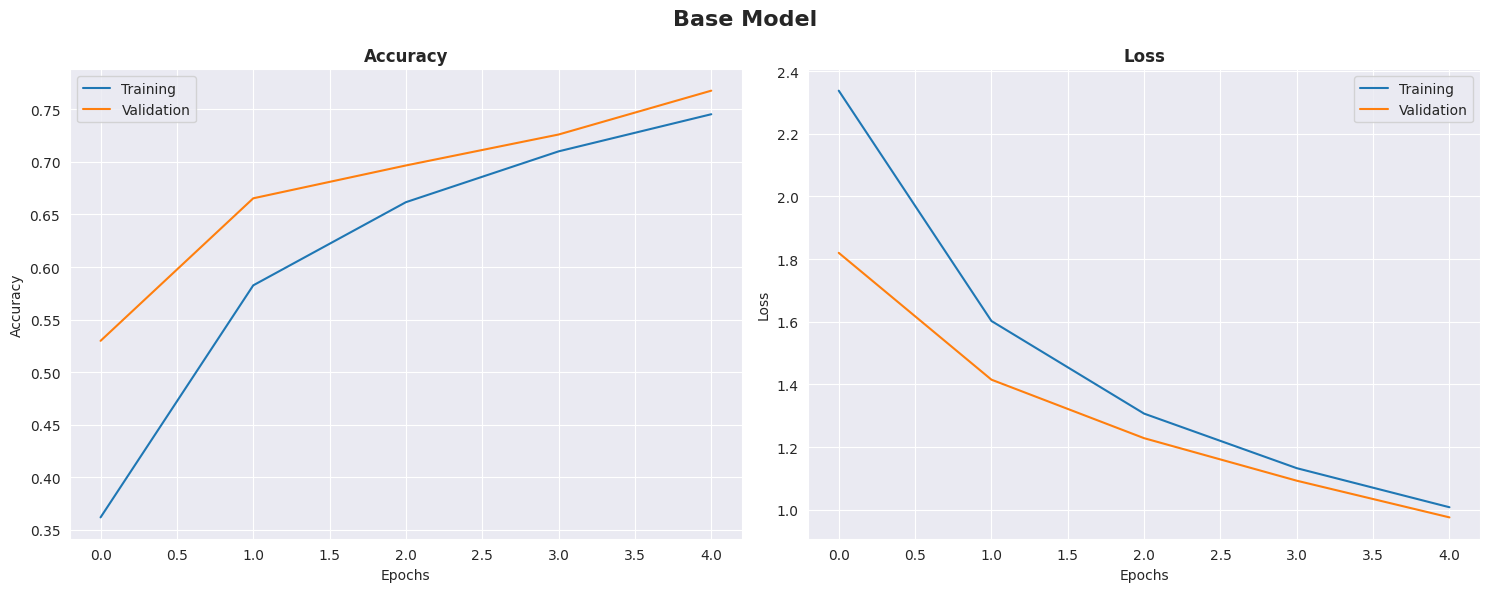

In [14]:
# compile and train model for 5 epochs
base_results = compile_and_train(base_model, epochs=5)

# print accuracy and plot training history
print_accuracy(base_results["accuracy"], "Base Model")
print()
plot_history(base_results["history"], title="Base Model")

### Model that overfits <a id="impl_4"></a>

With the basic model created, an overfitting model will be created next. Overfitting happens when a model memorises the training data instead of learning the patterns from it, leading to a model that does not perform well on unseen data. By creating an overfitting model, observations can be made on the model's performance in such scenarios which will be useful in evaluating the effectiveness of techniques like regularization, aimed at reducing overfitting.

To create the overfitting model:

-   More and bigger layers: the model will now have three densely connected layers with 128, 64, and 32 units each. Each of the added dense layers will use the ReLU (Rectified Linear Unit) activation function which enhances the model's ability to fit the training data more closely

-   Train for more epochs: The model will now be trained for 100 epochs.

-   Everything else like the last-layer activation, optimizer, loss function, etc., will be kept the same as the base model.

When more layers and units are added, the number of trainable parameters significantly increases and eventually leads to the neural network memorising the training data, which causes overfitting to occur.


In [15]:
# model with more and larger layers
overfit_model = Sequential(
    [
        Dense(128, input_shape=(INPUT_SHAPE,), activation="relu"),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(OUTPUT_CLASSES, activation="softmax"),
    ],
    name="overfitting_model",
)

overfit_model.summary()

Model: "overfitting_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 24)                792       
                                                                 
Total params: 111608 (435.97 KB)
Trainable params: 111608 (435.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Result of overfitting model

The plot below shows the accuracy and loss of the overfitted model over 100 epochs during training and validation. From the plot, the training accuracy shows quick increase within the first 20 epochs, then plateaus near 100%. The training loss drops rapidly in the first 20 epochs to almost 0, which is consistent with the accuracy observed. On the other hand, although the validation accuracy also shows similar rapid increase during the first 20 epochs, it begins fluctuating and does not reach as high as the training accuracy. The validation loss is also consistent with the accuracy observed, where it shows spikes of increased loss.

The gap between the training and validation accuracy and loss is a clear indication of overfitting where it performs significantly better on the training data than on the unseen validation data.


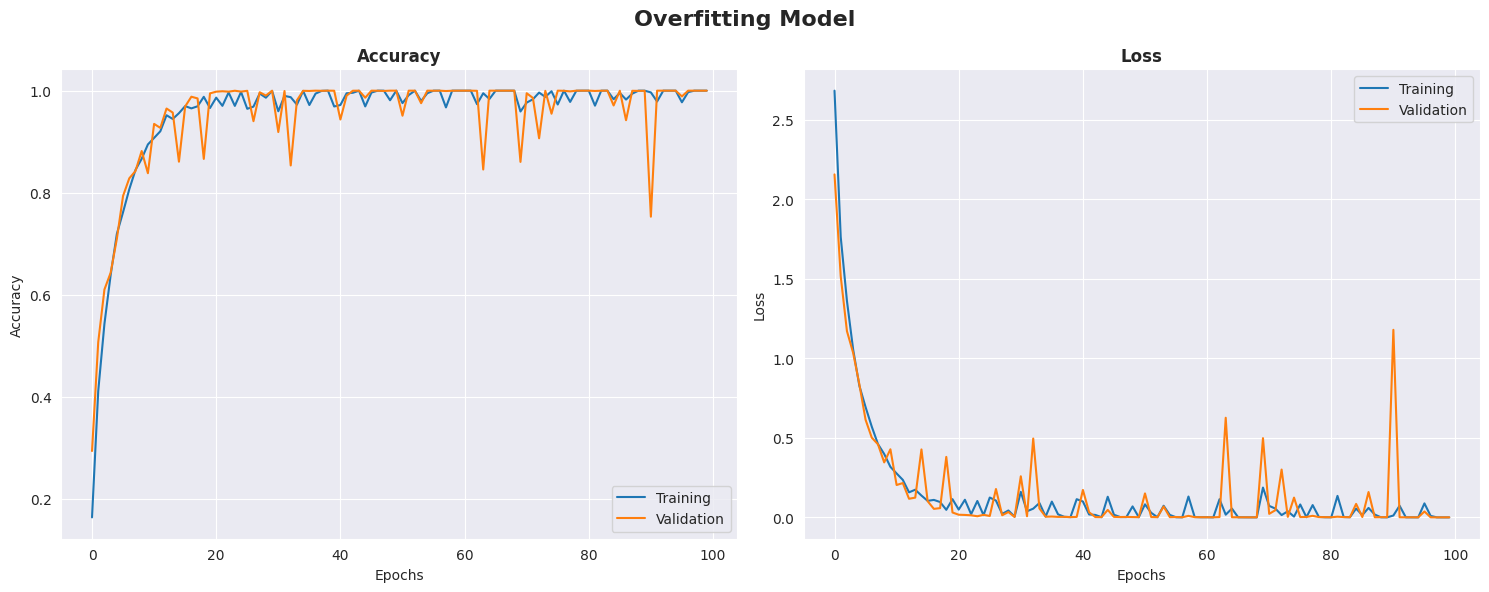

In [16]:
# compile and train model for 100 epochs
overfit_results = compile_and_train(overfit_model, epochs=100)

# plot training history
plot_history(overfit_results["history"], title="Overfitting Model")

### Regularization <a id="impl_5"></a>

Now that a base model and a overfitted model has been created, the next objective is to mitigate overfitting by regularizing the model. This process is important as it would enhance the model's generalization ability, ensuring that it can perform well on unseen data.

Regularization can be achieved through techniques such as adding dropout layers, introducing L1 and/or L2 regularization to the Dense layers, and implementing early stopping.

To better understand how each technique impacts the model's performance, separate models will be constructed with individual application of each technique. To ensure fair evaluation, each of the model will start with the same configurations as the overfitted model.


#### 1. Early Stopping

Early stopping is a method where the model's performance on the validation set is monitored during training. When it is detected that the model is starting to overfit either when performance starts to reach a constant, or starts to get poor, the training process will be stopped. This technique is effective in preventing overfitting as it stops the training before the model is able to memorise the training data. Additionally, early stopping also saves time and computational resources since unnecessary epochs are eliminated.


In [17]:
# get configuration of overfit model
overfit_config = overfit_model.get_config()

# create model with same configuration
early_stop_model = Sequential.from_config(overfit_config)
early_stop_model._name = "early_stop_model"

# verify configuration
early_stop_model.summary()

Model: "early_stop_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 24)                792       
                                                                 
Total params: 111608 (435.97 KB)
Trainable params: 111608 (435.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Result**

With early stopping implemented, one main observation from the traininig history plot below is that it stops before reaching 50 epochs, which suggests that early stopping was indeed applied. Comparing this result with the one achieved by the overfitted model before, the gap between the training and validation accuracy and loss appear to be smaller. These observations suggests that less overfitting is occuring, which demonstrates the effectiveness of early stopping as a regularization technique.

Given the effectiveness of applying early stopping, especially in terms of computational efficiency, subsequent models will have early stopping applied.


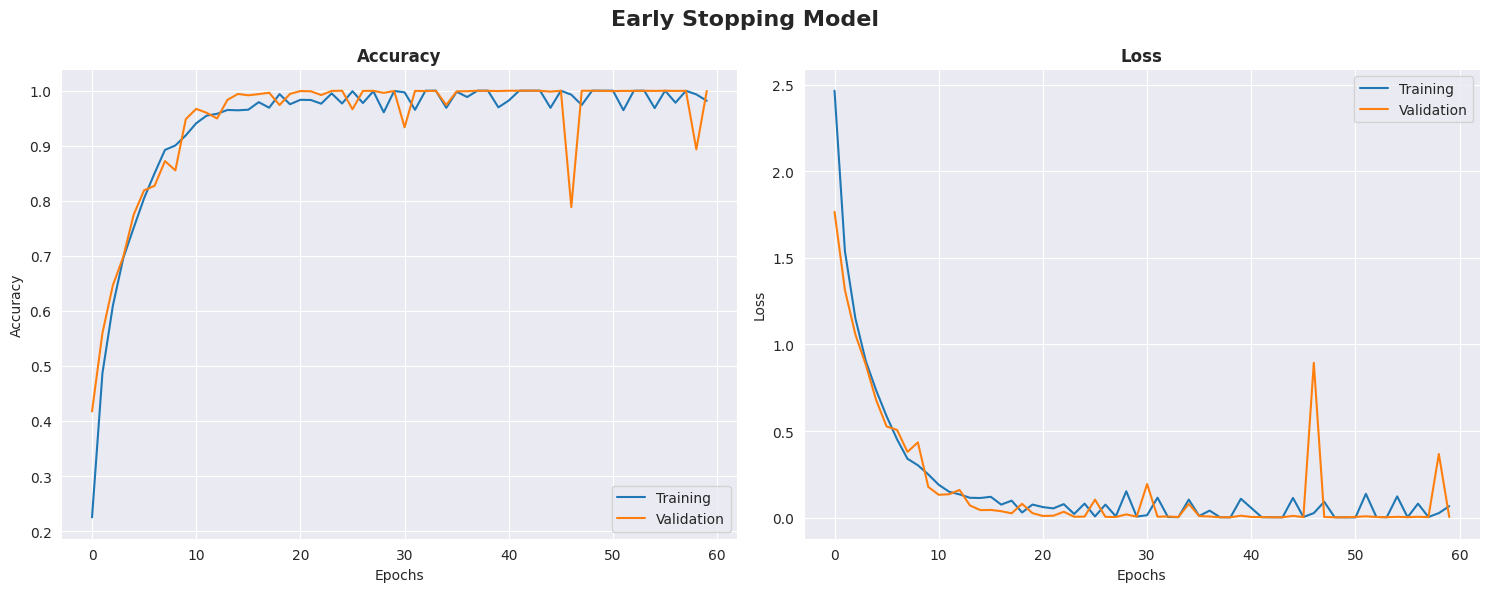

In [18]:
# train model for 100 epochs with early stopping
early_stop_results = compile_and_train(early_stop_model, epochs=100, stop=10)

plot_history(early_stop_results["history"], title="Early Stopping Model")

#### 2. Adding Dropout Layers

When dropout layers are added, randomness is introduced where units are dropped from the network during the training process to prevent the model from depending too much on a single neuron, which might cause overfitting to occur. Important considerations when introducing dropout is the number of dropout layers added, the dropout rate used, and the placement of the dropout later. If too many dropout layers are added, or if the dropout rates are set too high, too much randomness would be introduced, leading to the model losing information and end up underfitting.


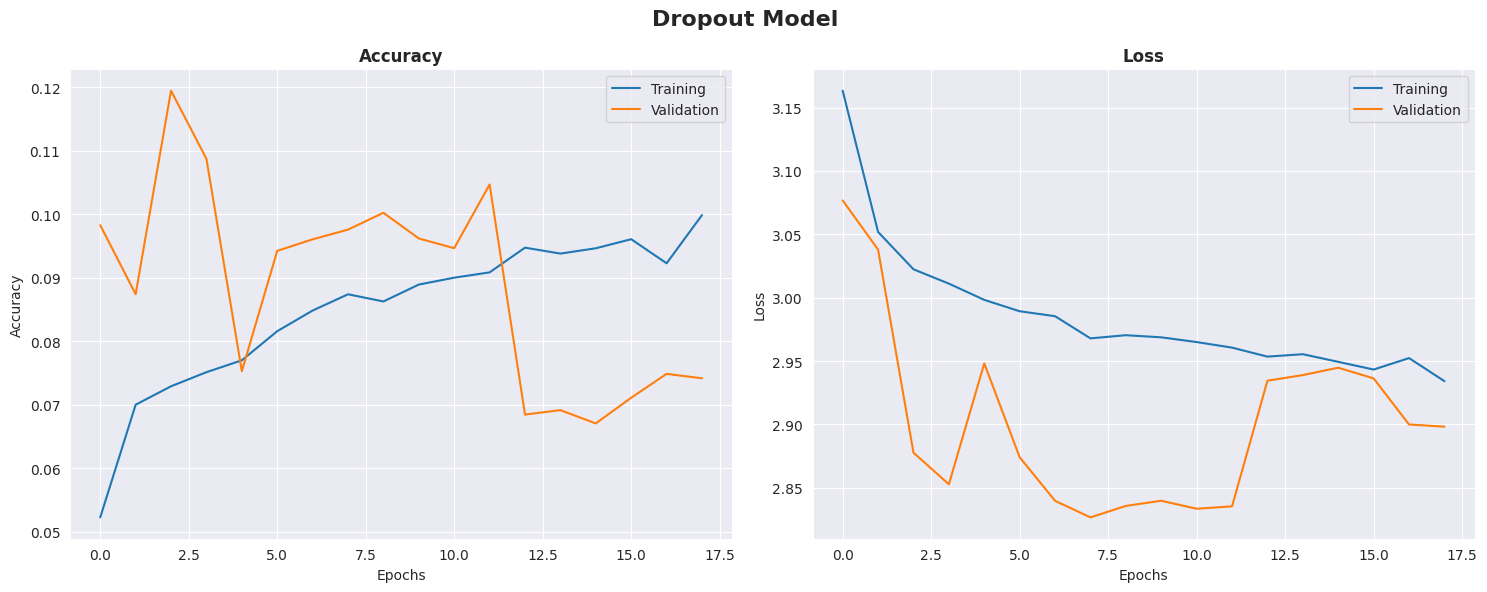

In [19]:
# model with dropout layers
dropout_model = Sequential(
    [
        Dense(128, input_shape=(INPUT_SHAPE,), activation="relu"),
        Dropout(0.5),
        Dense(64, activation="relu"),
        Dropout(0.4),
        Dense(32, activation="relu"),
        Dense(OUTPUT_CLASSES, activation="softmax"),
    ],
    name="dropout_model",
)

# train for 100 epochs with early stopping
dropout_results = compile_and_train(dropout_model, epochs=100, stop=10)

plot_history(dropout_results["history"], title="Dropout Model")

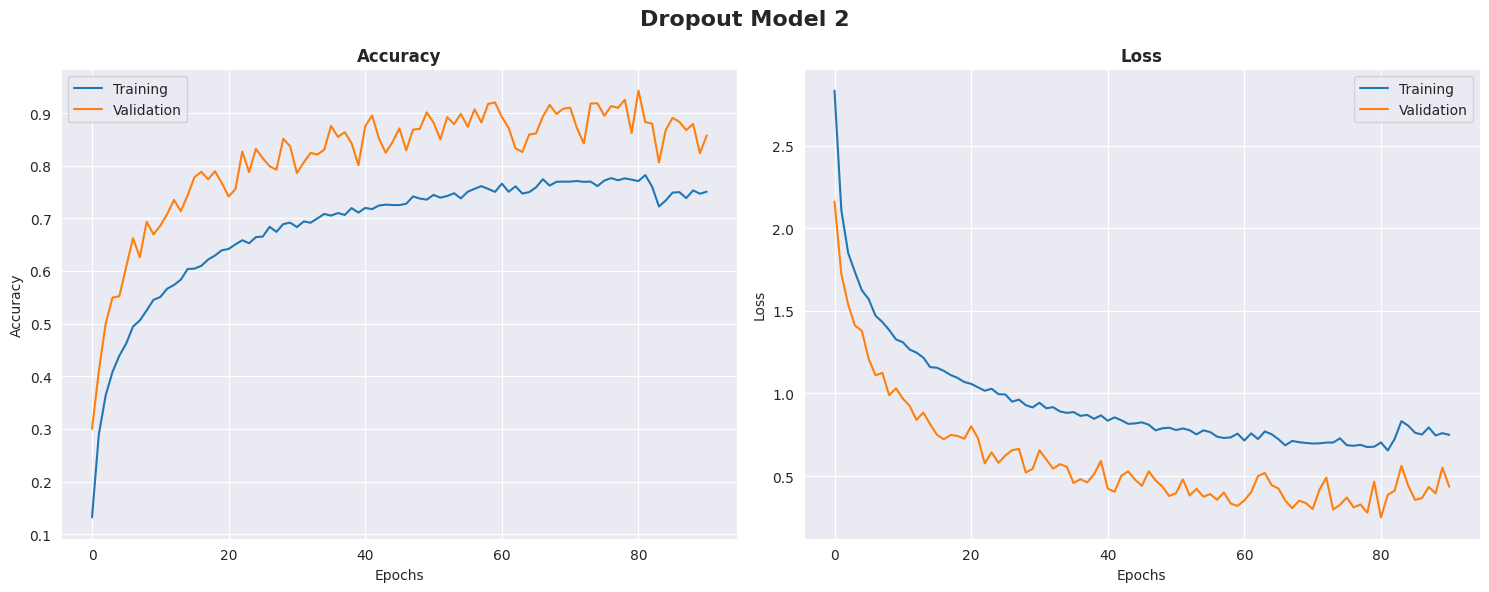

In [20]:
# model with dropout layers
dropout_model2 = Sequential(
    [
        Dense(128, input_shape=(INPUT_SHAPE,), activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(OUTPUT_CLASSES, activation="softmax"),
    ],
    name="dropout_model2",
)

# train for 100 epochs with early stopping
dropout2_results = compile_and_train(dropout_model2, epochs=100, stop=10)

plot_history(dropout2_results["history"], title="Dropout Model 2")

**Result**

Two different dropout layer configuration was explored: Initially, two dropout layers with dropout rates of 0.5 and 0.4 respectively was implemented. Consequently, the dropout rates were reduced to 0.2 for both layers while retaining the other model configurations.

The initial model exhibited poor validation accuracy, suggesting potential underfitting attributable to excessively high dropout rates being used. On the other hand, the second model yielded notably improved performance, evidenced by consistent increases in both training and validation accuracy as displayed on the training history plot.

The observed performance discrepancy between the two dropout layer configurations suggests the critical importance of determining an appropriate dropout rate selection in order to achieve the most optimal performance.


#### 3. Adding L1 regularization

L1 regularization (Lasso regularization) is where a penalty that is equivalent to the absolute value of the magnitude of the coefficients is added to the loss function. By doing so, more focus is placed on the important features in the training data so that the model can learn from those features while ignoring unimportant ones. This not only helps reduce the model's complexity, but also prevents overfitting.


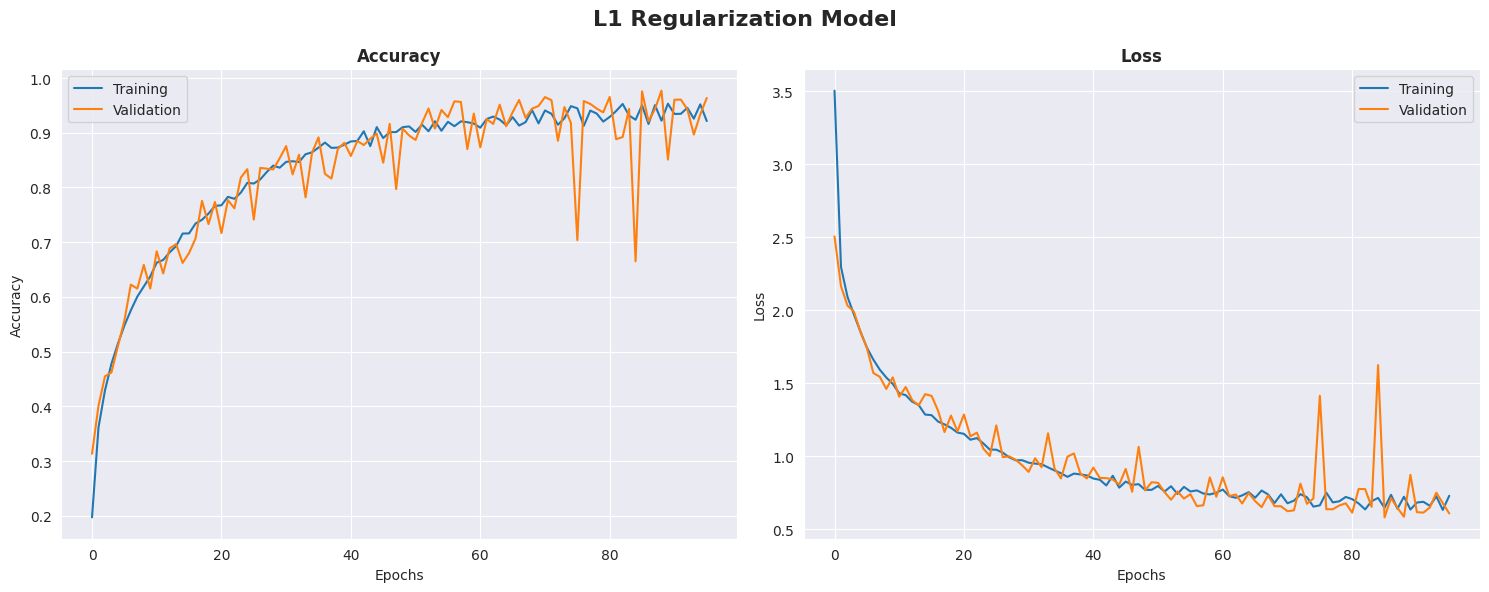

In [21]:
# with L1 regularization
l1_model = Sequential(
    [
        Dense(
            128,
            input_shape=(INPUT_SHAPE,),
            activation="relu",
            kernel_regularizer=l1(0.001),
        ),
        Dense(64, activation="relu", kernel_regularizer=l1(0.001)),
        Dense(32, activation="relu", kernel_regularizer=l1(0.001)),
        Dense(OUTPUT_CLASSES, activation="softmax"),
    ],
    name="l1_model",
)

# train for 100 epochs with early stopping
l1_results = compile_and_train(l1_model, epochs=100, stop=10)

plot_history(l1_results["history"], title="L1 Regularization Model")

#### 4. Adding L2 Regularization

L2 regularization (Ridge regularization) differs from L1 regularization where it penalizes the square of the coefficients. This technique reduces the impact of unimportant features, but does not lead to features being ignored entirely like in L1 regularization.


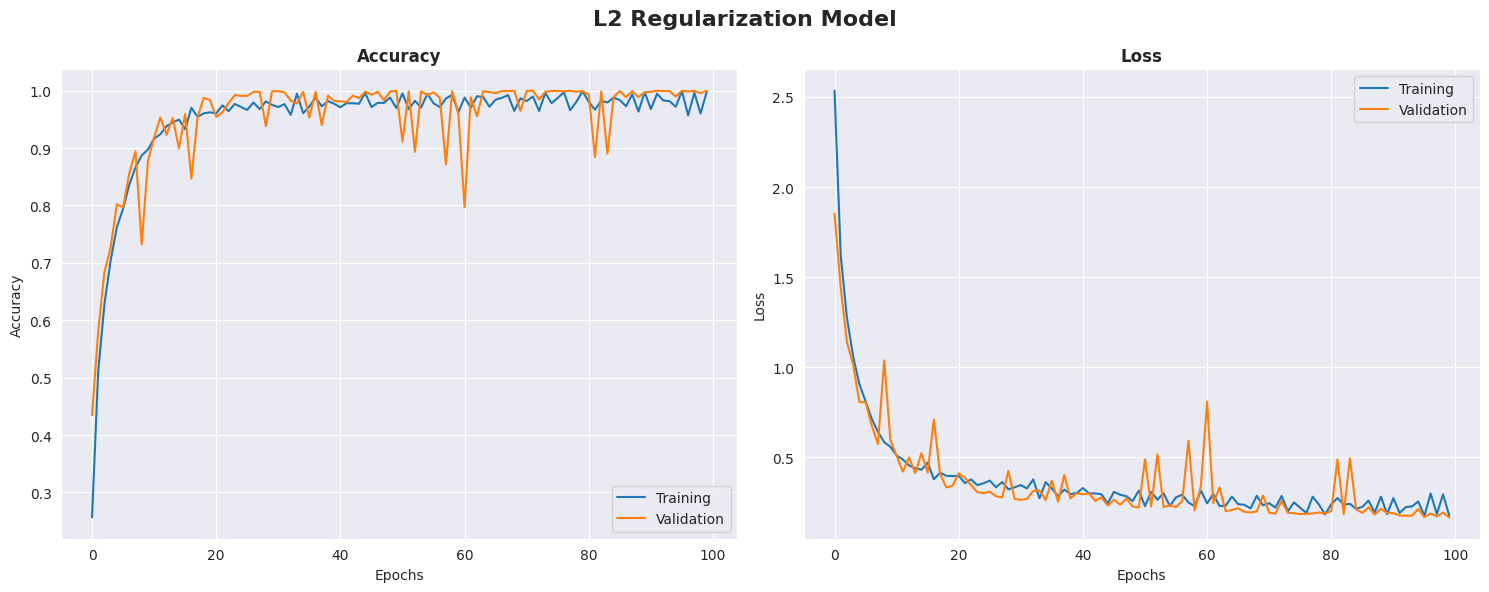

In [22]:
# with L2 regularization
l2_model = Sequential(
    [
        Dense(
            128,
            input_shape=(INPUT_SHAPE,),
            activation="relu",
            kernel_regularizer=l2(0.001),
        ),
        Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
        Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
        Dense(OUTPUT_CLASSES, activation="softmax"),
    ],
    name="l2_model",
)

# train for 100 epochs with early stopping
l2_results = compile_and_train(l2_model, epochs=100, stop=10)

plot_history(l2_results["history"], title="L2 Regularization Model")

#### 5. Adding both L1 and L2 Regularization

The combination of L1 and L2 regularization (Elastic Net) adds the penalty of both regularization techniques to the loss function, therefore offering the benefits of both methods.


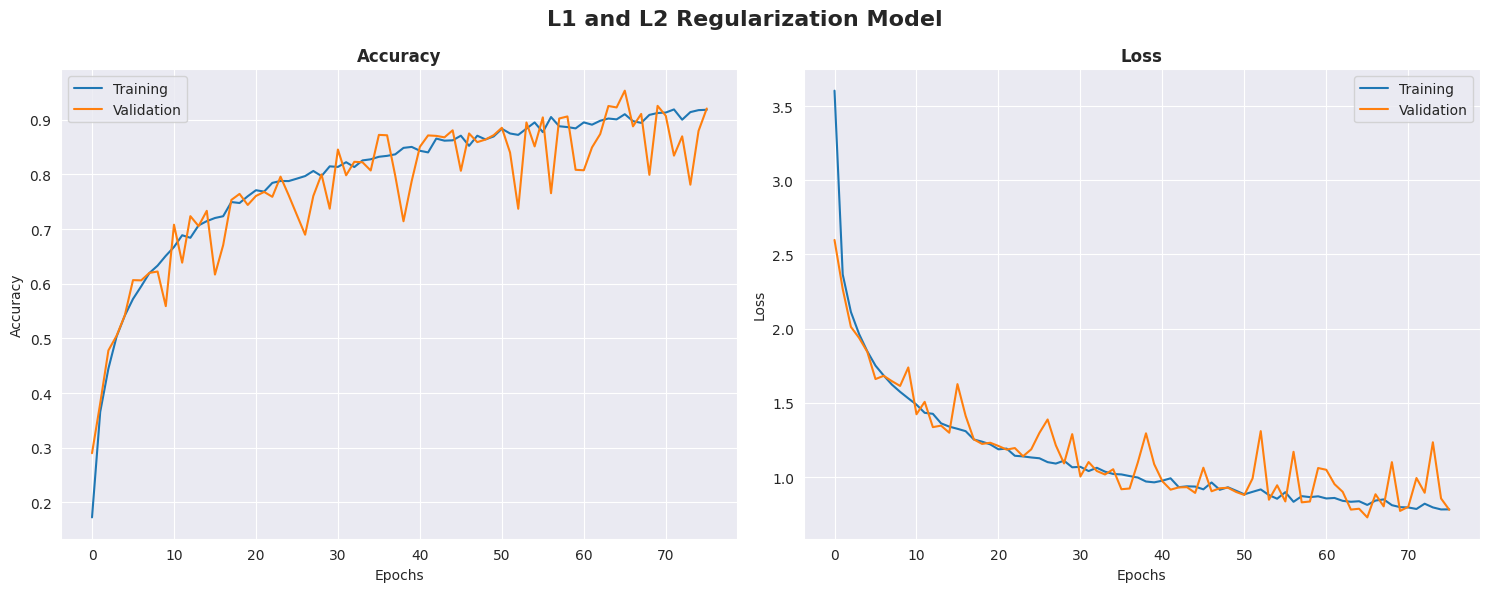

In [23]:
# with both L1 and L2 regularization
l1_l2_model = Sequential(
    [
        Dense(
            128,
            input_shape=(INPUT_SHAPE,),
            activation="relu",
            kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
        ),
        Dense(64, activation="relu", kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
        Dense(32, activation="relu", kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
        Dense(OUTPUT_CLASSES, activation="softmax"),
    ],
    name="l1_l2_model",
)

# train for 100 epochs with early stopping
l1_l2_results = compile_and_train(l1_l2_model, epochs=100, stop=10)

plot_history(l1_l2_results["history"], title="L1 and L2 Regularization Model")

**Observations**

3 different types of regularizations L1, L2 and L1_L2 were applied to create three different models using the same configurations.

1. L1 Regularization: Based on the training history plot for the L1 model, the training and validation accuracy lines are close together which indicates a fairly good generalisation ability. However, fluctuations can be observed in validation loss which suggests that the model might be suffering from high variance at certain points during training.

2. L2 Regularization: For the L2 regularization model, a high and consistent accuracy can be observed for both training and validation, with less noise compared to the L1 model. The validation loss is also relatively stable, suggesting that this model is generalizing well without the high-variance patterns observed in the L1 model.

3. L1 and L2 Regularization: Lastly, the L1_L2 model which combines both L1 and L2 regularization shows good generalization with the validation accuracy closely following the training accuracy. However, like the L1 model, some fluctuations can be observed.

Based on these observations, the Model with L2 regularization added resulted in the best performance in terms of generalization as compared to the two other models. This result aligns with the expectations for this project's task where every feature in the Sign Language MNIST dataset is relevant, making L2 regularization the most appropriate.


In [25]:
print_accuracy(l2_results["accuracy"], "L2 Regularization Model")

Accuracy of L2 Regularization Model: 99.99%


### Hyperparameter Tuning <a id="impl_6"></a>

To find the most optimal combination of hyperparameters, a grid search function has been implemented below. For each combination of a predefined grid of hyperparameter values, the model is trained on the training set and evaluated on the validation set. The combination that performs best on the validation set is then selected.

Hyperparameters that will be tuned:

-   Number of layers and neurons in each dense layer.
-   Dropout rate in dropout layers.
-   Regularization strength for L2 regularisation.


In [25]:
def create_model(num_layers, num_neurons, dropout_rate, reg_val):
    """
    Creates a neural network model with the given number of layers,
    number of neurons, dropout rate and regularization value.

    Params:
        - num_layers: Number of dense layers in the model
        - num_neurons: Number of neurons in each dense layer
        - dropout_rate: Dropout rate for each dropout layer
        - reg_val: Regularization strength for each dense layer

    Returns:
        A compiled neural network model
    """
    model = Sequential()
    model.add(
        Dense(
            num_neurons,
            input_shape=(INPUT_SHAPE,),
            activation="relu",
            kernel_regularizer=l2(reg_val),
        )
    )
    model.add(Dropout(dropout_rate))

    for _ in range(num_layers - 1):
        model.add(Dense(num_neurons, activation="relu", kernel_regularizer=l2(reg_val)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(OUTPUT_CLASSES, activation="softmax"))

    return model


def grid_search(X_train, y_train, X_val, y_val, params):
    """
    Performs a grid search to find the best hyperparameters for the model.

    Params:
        - X_train: Training features
        - y_train: Training labels
        - X_val: Validation features
        - y_val: Validation labels
        - params: Dictionary of hyperparameters to search

    Returns:
        A tuple containing the best hyperparameters and the best accuracy score
    """
    best_score = 0
    best_params = {}

    for param in ParameterGrid(params):
        model = create_model(
            param["num_layers"],
            param["num_neurons"],
            param["dropout_rate"],
            param["reg_val"],
        )

        model.compile(
            optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
        )

        # use early stopping
        early_stopping = EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True
        )

        # train model on train set
        model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            epochs=100,
            callbacks=[early_stopping],
            verbose=0,
        )

        # evaluate model
        score = model.evaluate(X_val, y_val, verbose=0)[1]

        # check and keep best score
        if score > best_score:
            best_score = score
            best_params = param

    return best_params, best_score

In [26]:
# hyperparameters to tune
params = {
    "num_layers": [1, 2, 3],
    "num_neurons": [32, 64, 128],
    "dropout_rate": [0.2, 0.3],
    "reg_val": [0.001, 0.01, 0.1],
}

# perform grid search
best_params, best_score = grid_search(X_train, y_train, X_val, y_val, params)

print("Best parameters:", best_params)
print("Best validation accuracy:", best_score)

Best parameters: {'dropout_rate': 0.2, 'num_layers': 1, 'num_neurons': 128, 'reg_val': 0.001}
Best validation accuracy: 0.9521751403808594


### Evaluation <a id="impl_7"></a>

With the best hyperparameter combination identified above, the final best model will be created using those hyperparemeters. After that, it will be retrained on the training data, then finally evaluated on the test set.


In [39]:
# create model with best hyperparameters
final_model = create_model(
    best_params["num_layers"],
    best_params["num_neurons"],
    best_params["dropout_rate"],
    best_params["reg_val"],
)

final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 24)                3096      
                                                                 
Total params: 103576 (404.59 KB)
Trainable params: 103576 (404.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
# compile model
final_model.compile(
    optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
)

# use early stopping
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# train model on train set
final_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[early_stopping],
    verbose=0,
)

# evaluate on test set
final_loss, final_accuracy = final_model.evaluate(X_test, y_test, verbose=0)

print_accuracy(final_accuracy, "Final Model")

Accuracy of Final Model: 63.89%


**Observation of final model**

The final model which was constructed with the optimal hyperparameters identified through hyperparameter tuning achieved an accuracy of 63.89% on the test set. This is a substantial improvement over the common sense baseline of 4.17%. Despite so, the performance of the final model falls short of the base model's 76.77%

Furthermore, it is observed that during the process of hyperparameter tuning, the most optimal combination of hyperparameters yielded a validation accuracy of 95%. Unfortunately, this performance did not translate to the test set evaluation. This discrepancy suggests that the model may be overfitting to the validation set and not generalizing well to unseen data. It could also indicate that a more extensive hyperparameter tuning process is required.


225/225 [==============================] - 1s 2ms/step


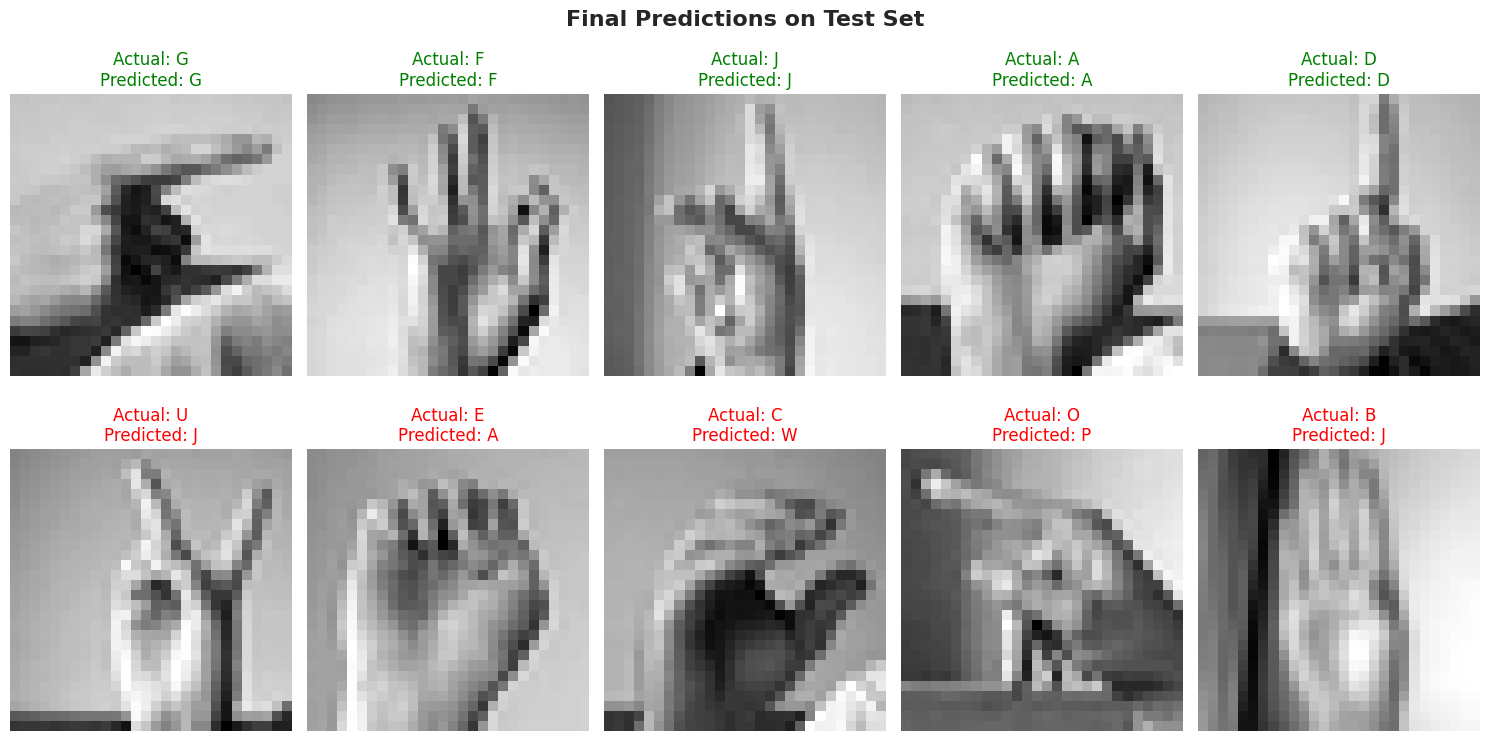

In [41]:
def plot_predictions(predictions, labels, imgs, title):
    """
    Plots the first 5 correct and incorrect predictions
    """
    # convert pred and labels to alphabets
    labels = np.argmax(labels, axis=1)
    labels = [chr(65 + i) for i in labels]

    predictions = np.argmax(predictions, axis=1)
    predictions = [chr(65 + i) for i in predictions]

    # get correct and incorrect predictions
    correct_indices = [i for i, (p, l) in enumerate(zip(predictions, labels)) if p == l]
    incorrect_indices = [
        i for i, (p, l) in enumerate(zip(predictions, labels)) if p != l
    ]

    # plot correct predictions on top row
    plt.figure(figsize=(15, 8))
    for i in range(5):
        idx = correct_indices[i]
        actual = labels[idx]
        predicted = predictions[idx]

        plt.subplot(2, 5, i + 1)
        plt.imshow(imgs[idx].reshape(28, 28), cmap="gray")
        plt.title(f"Actual: {actual}\nPredicted: {predicted}", color="green")
        plt.axis("off")

    # plot false predictions on bottom row
    for i in range(5):
        idx = incorrect_indices[i]
        actual = labels[idx]
        predicted = predictions[idx]

        plt.subplot(2, 5, i + 6)
        plt.imshow(imgs[idx].reshape(28, 28), cmap="gray")
        plt.title(f"Actual: {actual}\nPredicted: {predicted}", color="red")
        plt.axis("off")

    plt.suptitle(title, fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.show()


# get predictions
predictions = final_model.predict(X_test)

plot_predictions(predictions, y_test, X_test, "Final Predictions on Test Set")

## Conclusion <a class="anchor" id="concl"></a>

In this project, a systematic and structured approach to machine learning, as prescribed by François Chollet, was closely followed to address the problem of identifying American Sign Language (ASL) letters from the Sign Language MNIST dataset.

Initially, a common sense baseline accuracy of 4.17% was established through random guessing. This was subsequently surpassed by a basic model containing a single dense layer, achieving 76.77% accuracy after training for 5 epochs. This improvement from the baseline accuracy underscored the potential of Dense Neural Networks for the current task. Subsequently, an overfit model was created intentionally by adding multiple dense layers, and increasing the number of neurons. This model was trained over 100 epochs, resulting in an overfitting pattern where training accuracy was high while validation accuracy showed fluctuations.

Having established a clear case of overfitting, several regularization techniques (early stopping, dropout, L1 regularization, L2 regularization, Elastic Net) were explored to mitigate this overfitting issue. Each technique was applied to a model using the same configuration as the overfit model to understand its impact. Initial experiments with higher dropout rates led to poor performance. However, a recalibration of the dropout rates to lower values resulted in a vast improvement in performance. This underscored the importance of fine-tuning hyperparameters.

Through the implementation of a custom grid search function for hyperparameter tuning, it facilitated a comprehensive exploration of different model configurations to identify the most optimal combination of hyperparameters. These hyperparameters were then used to create the final model that was retrained on the entire training set. The final model's evaluation on the unseen test set revealed a suboptimal performance with an accuracy of 63.89%.

In conclusion, while the 63.89% accuracy achieved by the final model falls short of the base model's benchmark of 76.41% accuracy on the validation set, it did surpass the common sense baseline accuracy of 4.17% by a significant margin. This suggests that the model still shows some effectiveness in identifying ASL letters, but would require further model refinement to achieve better performance.
